<a href="https://colab.research.google.com/github/mediatrang/AlphaTeleco/blob/main/GAMI__AD_HOC_REPORT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**WELCOME TO GAMI AD_HOC REPORTING**

Toàn bộ dữ liệu được lấy từ thời điểm Gami có ghi nhận data đến ngày **06/02/2021**

*Cách sử dụng: Chỉ cần ấn vào các nút theo thứ tự, xin đừng chỉnh sửa bất cứ code nào trong trang này*

*Toàn bộ chart đều là interactive charts, di chuyển con chuột vào vùng chart để xem dữ liệu, di chuyển con trỏ đến góc trên cùng bên phải của chart sẽ có các icon nhỏ, cho phép, phóng to thu nhỏ, hoặc trở về kích cỡ mặc định.
Di chuyển con trỏ vào vùng chart , giữ con trỏ để phóng to vùng chart cần xem*

tab run: là các tab chứa code màu sậm

Cách run từng tab:
Di chuyển con trỏ vào khu vực chart cho đến khi thấy xuất hiện icon thì click vào 
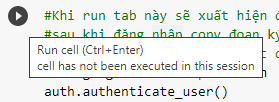

Cách phóng to một khu vực trong chart :
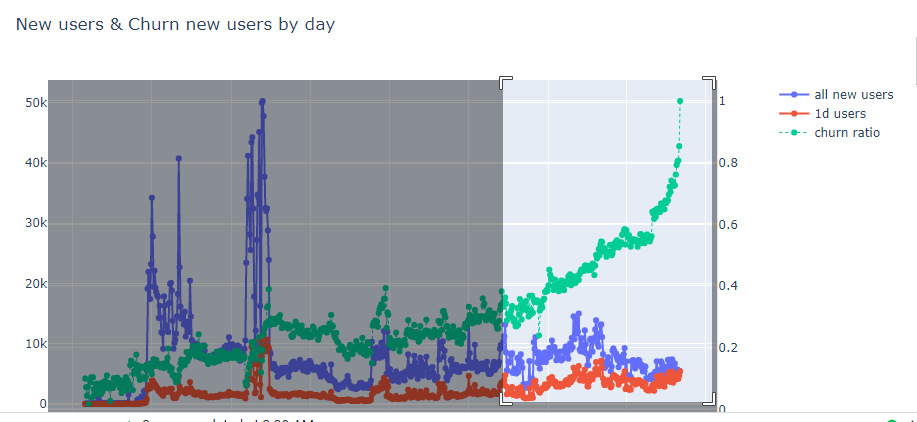

**INTRODUCTION**

Report này bao gồm 2 phần chính:

-New users: Số lượng churn, tỉ lệ churn của new users

-Core users: 
* số lượng churn của core users theo thời gian
* mức độ active của core users 


In [ ]:
#Khi run tab này sẽ xuất hiện đường link, click vào đường link sẽ bị yêu cầu đăng nhập vào email công ty, 
#sau khi đăng nhập copy đoạn ký tự được trả về -> paste vào khoảng trống và nhấn enter.
# Nếu mail của bạn không được quyền access xin vui lòng liên lạc Trang để được trợ giúp
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

In [ ]:
%%bigquery --project momovn-prod df
SELECT * 
FROM `momovn-prod.REPORT.ANALYZE_ACTIVE_USER`

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## DATA PROCESSING

In [ ]:
df['START_DATE'] = df['START_DATE'].astype('datetime64')
df['month'] =df['START_DATE'].dt.month
df['year'] = df['START_DATE'].dt.year

df1 = df.groupby(['START_DATE'])['PHONE'].nunique().reset_index(name ='all_new_user')
df_1d = df[df.NUM_ACTIVE_DAYS == 1].groupby(['START_DATE'])['PHONE'].nunique().reset_index(name ='1d_new_users')

df_all = df1.merge(df_1d, on = 'START_DATE', how = 'outer')
df_all['ratio'] = df_all['1d_new_users']/df_all['all_new_user']
df_all['year'] = df_all['START_DATE'].dt.year

# 
 df['ACTIVE_LEVEL_TENURE'] = 100*df['NUM_ACTIVE_DAYS']/df['TENURE']
 # ACTIVE_LEVEL_TENURE: SO NGAY CHOI/(NGAY HIEN TAI - NGAY START)
 # NOTE: ngay hien tai duoc tinh laf 02/06 ke tu thoi diem lay data
 df['ACTIVE_LEVEL_CURRENT'] = 100* df['NUM_ACTIVE_DAYS']/df['START_TO_CURRENT']

## NEW USERS AND CHURN NEW USERS


In [ ]:
## Line chart_ New users & churn new users
fig = make_subplots(specs= [[{'secondary_y': True}]])

fig.add_trace(go.Scatter(x= df1['START_DATE'], y= df1['all_new_user'], mode='lines+markers', name='all new users'), secondary_y =False)
fig.add_trace(go.Scatter(x= df_1d['START_DATE'], y= df_1d['1d_new_users'], mode='lines+markers', name = '1d users'), 
                         secondary_y =False)
fig.add_trace(go.Scatter(x = df_all['START_DATE'], y= df_all['ratio'], mode = 'lines+markers',
                         name ='churn ratio', line =dict(width =1, dash = 'dot')), secondary_y =True)
fig.update_layout(title_text ='New users & Churn new users by day')

## CORE USERS _ CHURN

**CORE_USERS**

Core user hiện tại là các user có  tỉ lệ ratio:
số ngày chơi / (số ngày từ lúc bắt đầu chơi -> 06/02/2021)  lớn hơn 0.7.

Note: Nếu muốn thay đổi định nghĩa về core user , cụ thể thay đổi giá trị ratio, vui lòng thay đổi ở tab chứa dòng **'ratio = 70'** bên dưới. Hiện giá trị mặc định là 70.

Click run tab , run tiếp các tab phía dưới tab bị thay đổi và xem kết quả các chart sau khi bị thay đổi

####**Histogram số ngày actives của CORE USERS**
* ACTIVE_LEVEL_TENURE: SO NGAY CHOI/ TENURE

*TENURE là số ngày từ lúc user bắt đầu chơi đến ngày cuối cùng có ghi nhận user active*

* ACTIVE_LEVEL_CURRENT: SO NGAY CHOI/(NGAY HIEN TAI - NGAY START)

* NOTE: ngay hien tai duoc tinh laf 02/06 ke tu thoi diem lay data

In [129]:
#Thay đổi giá trị ratio ở tab này
ratio = 50

In [130]:
test = df[df.ACTIVE_LEVEL_CURRENT >ratio]
fig = px.histogram(test, x="NUM_ACTIVE_DAYS", nbins= 30)
fig.update_layout(title_text ='Histogram số ngày actives của các core_users',
                  yaxis =dict(title = 'Số lượng users'),
                  xaxis = dict(title = 'Số ngày active'),
                  bargap =0.1)
fig.show()

In [131]:
# Tạo tệp core user
#core = df[(df.ACTIVE_LEVEL_CURENT >ratio) & (df.NUM_ACTIVE_DAYS >= 30)].sort_values(
#    by =['ACTIVE_LEVEL_CURENT','NUM_ACTIVE_DAYS'],ascending =False)
core = df[df.ACTIVE_LEVEL_CURRENT >ratio].sort_values(
    by =['ACTIVE_LEVEL_CURRENT','NUM_ACTIVE_DAYS'],ascending =False)
core['DATE'] =core['CURENT_DATE'].apply(lambda x: str(x)[:7])

####**Bar_chart thể hiện số lượng core_users được ghi nhận ngày cuối cùng active tại các ngày**

xaxis: ngày ghi nhận lần cuối users active

yaxis : số core users

In [132]:
# NUMBER OF CHURN_CORE USERS BY DAY
check = core[~core.DATE.isin(['2021-05', '2021-06'])]
check = check.groupby(['CURENT_DATE'])['PHONE'].nunique().reset_index().sort_values(by =['PHONE'], ascending =False)

test = check
fig = px.bar(test, x= 'CURENT_DATE', y = 'PHONE', text = 'PHONE')
fig.update_layout(title_text = 'CORE_USERS CHURN BY DAY',
                  xaxis = dict(title = 'End Date'),
                  yaxis = dict(title = 'Number of users'))
fig

####**BAR_CHART: CORE_USERS CHURN BY MONTH**

xaxis: tháng ghi nhận lần cuối core users hoạt động

yaxis: số lượng core users

In [133]:
#Core churn users by month
check = core[~core.DATE.isin(['2021-05', '2021-06'])]
check = check.groupby(['DATE'])['PHONE'].nunique().reset_index().sort_values(by =['PHONE'], ascending =False)

test = check
fig = px.bar(test, x= 'DATE', y = 'PHONE', text = 'PHONE')
fig.update_layout(title_text = 'CORE_USERS CHURN BY MONTH',
                  xaxis = dict(title ='Number of churn_core users'),
                  bargap =0.1)
fig

####Core users starts by day

x_axis: ngày mà core users bắt đầu chơi

y_axis: số lượng core users 

In [134]:
# NUMBER OF CHURN_CORE USERS BY DAY
check = core[~core.DATE.isin(['2021-05', '2021-06'])]
check = check.groupby(['START_DATE'])['PHONE'].nunique().reset_index().sort_values(by =['PHONE'], ascending =False)

test = check
fig = px.bar(test, x= 'START_DATE', y = 'PHONE', text = 'PHONE')
fig.update_layout(title_text = 'CORE_USERS BEGIN BY DAY',
                  xaxis = dict(title = 'Start Date'),
                  yaxis = dict(title = 'Number of users'))
fig

##**CORE USER DEMOGRAPHIC**

In [ ]:
df